<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/TPOT/blood_transfusion/keras_tuner_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%pip install -q keras-tuner
%pip show keras-tuner scikit-learn

Name: keras-tuner
Version: 1.0.1
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tqdm, numpy, scipy, scikit-learn, tabulate, colorama, terminaltables, requests, future
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, scipy, numpy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


[輸血データセット:https://www.openml.org/d/1464](https://www.openml.org/d/1464)

In [21]:
import datetime, IPython, os 

import numpy as np

from kerastuner import HyperModel, Hyperband
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from tensorflow.keras import Sequential, layers, callbacks, optimizers
from tensorflow.keras.utils import plot_model

# データ読み込み

In [9]:
%%time
DATA_ID = '1464' #@param{type:'string'}

# データセットをフェッチ
X, y = fetch_openml(data_id=DATA_ID, return_X_y=True, as_frame=True)

def processing_y(y):
    '''ラベルyの加工'''
    def _convert_dtype(type='int64'):
        '''dtype: category(文字列型)をint64に変更'''
        return y.astype('int64')
    
    def _indicator_start_0():
        '''インディケータ開始の数を0にする'''
        return y - y[np.argmin(y)]

    y = _convert_dtype()
    y = _indicator_start_0()
    return y

y = processing_y(y)
display(X)
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))

,V1,V2,V3,V4
0,2.0,50.0,12500.0,98.0
1,0.0,13.0,3250.0,28.0
2,1.0,16.0,4000.0,35.0
3,2.0,20.0,5000.0,45.0
4,1.0,24.0,6000.0,77.0
...,...,...,...,...
743,23.0,2.0,500.0,38.0
744,21.0,2.0,500.0,52.0
745,23.0,3.0,750.0,62.0
746,39.0,1.0,250.0,39.0


0      1
1      1
2      1
3      1
4      0
      ..
743    0
744    0
745    0
746    0
747    0
Name: Class, Length: 748, dtype: int64

'train shape:(478, 4)'

'val shape:(120, 4)'

'test shape:(150, 4)'

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 39.1 ms


# モデル構築

In [10]:
class BloodHyperModel(HyperModel):

      def __init__(self, input_shape, num_classes, train_X_np):
          self.input_shape = input_shape
          self.num_classes = num_classes
          self.norm_layer = self._setupNormalizationLayer(X=train_X_np)
      

      def _setupNormalizationLayer(self, X):
          '''正規化の前処理レイヤーを初期化'''
          norm_layer = layers.experimental.preprocessing.Normalization()
          norm_layer.adapt(X)
          return norm_layer


      def build(self, hp):
          '''モデル構造と探索空間の定義'''
          model = Sequential()
          model.add(layers.Input(shape=self.input_shape))

          hp_processing_layer = hp.Boolean('is_processing_layer', default=False)
          if hp_processing_layer:
              model.add(self.norm_layer)
            
          for i in range(hp.Int('num_layers', min_value=2, max_value=10, step=1)):
              units = hp.Int('units_'+str(i), min_value=16, max_value=128, step=16)
              model.add(layers.Dense(units=units, activation='relu'))
              model.add(layers.Dropout(rate=0.3))

          model.add(layers.Dense(self.num_classes, activation='sigmoid'))

          model.compile(
              optimizer=optimizers.Adam(
                  hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4])),
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])
          
          return model

In [11]:
input_shape = (train_X.shape[1], )
# 2値分類のため今回は1を設定
NUM_CLASSES = 1

# Hyperbandアルゴリズムの試行回数(default:1)
HYPERBAND_ITERATIONS = 1 #@param{type:'number'}
# Hyperbandアルゴリズムで使用する削減率(default:3)
FACTOR = 3 #@param{type:'number'}
# 1つあたりのモデルのEpoch数
MAX_EPOCHS = 10 #@param{type:'number'}
SEED = 7


hyper_model = BloodHyperModel(input_shape=input_shape,
                              num_classes=NUM_CLASSES,
                              train_X_np=train_X.values)
display(hyper_model)

tuner = Hyperband(hypermodel=hyper_model,
                  objective='val_accuracy',
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=2)

class ClearTrainingOutput(callbacks.Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [12]:
%%time
tuner.search(train_X.values, train_y.values,
             validation_data=(val_X.values, val_y.values),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

INFO:tensorflow:Oracle triggered exit
CPU times: user 40.6 s, sys: 1.86 s, total: 42.5 s
Wall time: 43.4 s


# ベストなモデルの可視化

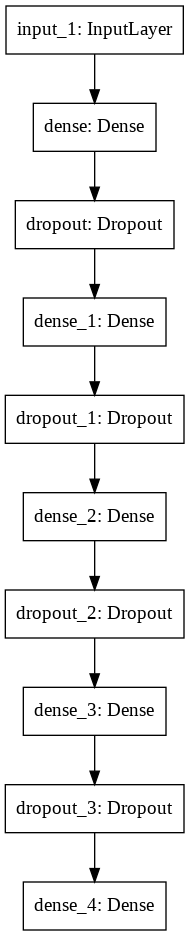

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                10320     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

None

{'is_processing_layer': False,
 'learning_rate': 0.001,
 'num_layers': 4,
 'tuner/bracket': 2,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 32,
 'units_1': 128,
 'units_2': 80,
 'units_3': 32}

In [13]:
def display_best_model(tuner):
    '''ベストなモデルの構造を表示'''
    best_model = tuner.get_best_models()[0]
    display(plot_model(best_model))
    display(best_model.summary())


def display_best_hp(tuner):
    '''ベストなハイパーパラメータを表示'''
    best_hp = tuner.get_best_hyperparameters()[0]
    display(best_hp.get_config()['values'])


display_best_model(tuner)
display_best_hp(tuner)

# モデルの評価

In [14]:
def take_best_model(tuner):
    '''ベストなモデルを取り出し'''
    best_model = tuner.get_best_models()[0]
    return best_model


model = take_best_model(tuner)   

## Kerasの組み込み評価関数

In [15]:
score = model.evaluate(x=test_X.values, y=test_y.values, batch_size=256)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

1/1 [==============================] - 0s 5ms/step - loss: 9.7625 - accuracy: 0.7467 - binary_crossentropy: 9.7625


'loss : 9.762469291687012, accuracy : 0.746666669845581'

## sklearnの評価関数

In [23]:
%%time
def predict_binary_class_label(model, threshold=0.5):
    '''二値分類モデルの予測結果から予測クラスを取り出し
    TODO: 諸々の作成'''

# 予測結果の取得
train_y_pred = model.predict(train_X)
val_y_pred = model.predict(val_X)
test_y_pred = model.predict(test_X)

train_report = classification_report (y_true=train_y, y_score=train_y_pred)
val_report = classification_report (y_true=val_y, y_score=val_y_pred)
test_report = roc_auc_classification_reportscore (y_true=test_y, y_score=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)



0.3189524785323966
----- -----
0.35054347826086957
----- -----
0.37394266917293234
